In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Referencia: https://www.kaggle.com/code/faressayah/collaborative-filtering-for-movie-recommendations/notebook

In [17]:
# movielens_data_file_url = (
#     "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# )

#lo baja en el directorio de keras ~/.keras
# movielens_zipped_file = keras.utils.get_file(
#     "ml-latest-small.zip", movielens_data_file_url, extract=False
# )

# keras_datasets_path = Path(movielens_zipped_file).parents[0]
# movielens_dir = keras_datasets_path / "ml-latest-small"
movielens_dir = Path("./") / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

df = pd.read_csv(ratings_file)
tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)

In [18]:
print(movielens_dir)


ml-latest-small


In [19]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [20]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [22]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 610, Number of Movies: 9724, Min Rating: 0.5, Max Rating: 5.0


In [24]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 100%
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [25]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [26]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)
    
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
    # mac m1/m2 performance, use tf.keras.optimizers.legacy.Adam 
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.legacy.Adam(lr=0.001),
    metrics=[root_mean_squared_error,'mae', 'accuracy']
)

/Users/hordia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
#     verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/5
1418/1418 [==============================] - 19s 13ms/step - loss: 0.6134 - root_mean_squared_error: 0.2071 - mae: 0.1628 - accuracy: 0.1333 - val_loss: 0.6155 - val_root_mean_squared_error: 0.2084 - val_mae: 0.1667 - val_accuracy: 0.1317
Epoch 2/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6089 - root_mean_squared_error: 0.2021 - mae: 0.1580 - accuracy: 0.1346 - val_loss: 0.6141 - val_root_mean_squared_error: 0.2066 - val_mae: 0.1641 - val_accuracy: 0.1330
Epoch 3/5
1418/1418 [==============================] - 19s 14ms/step - loss: 0.6082 - root_mean_squared_error: 0.2009 - mae: 0.1571 - accuracy: 0.1347 - val_loss: 0.6136 - val_root_mean_squared_error: 0.2059 - val_mae: 0.1631 - val_accuracy: 0.1322
Epoch 4/5
1418/1418 [==============================] - 20s 14ms/step - loss: 0.6067 - root_mean_squared_error: 0.1989 - mae: 0.1554 - accuracy: 0.1352 - val_loss: 0.6118 - val_root_mean_squared_error: 0.2039 - val_mae: 0.1610 - val_accuracy: 0.1315
Epoc

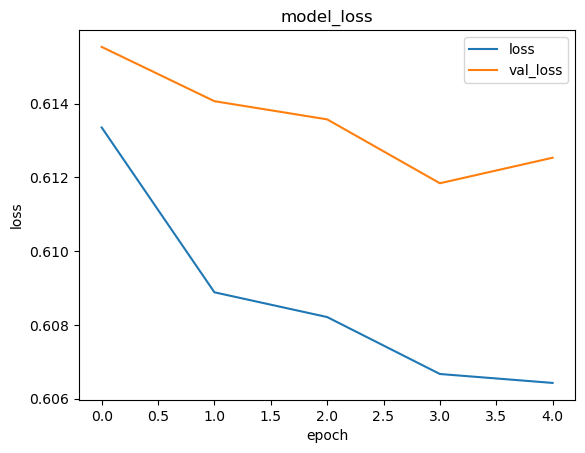

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [32]:
movie_df = pd.read_csv(movielens_dir / 'movies.csv')

user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[~movie_df['movieId'].isin(movies_watched_by_user.movieId.values)]['movieId']

movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))

movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]

recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

292/292 [==============================] - 2s 6ms/step


In [33]:
user_movie_array.shape


(9341, 2)

In [42]:
print(movies_not_watched[0])

[5804]


In [36]:
ratings.shape

(9341,)

In [35]:
print(user_movie_array[0])
type(user_movie_array[0])

[ 356 5804]


numpy.ndarray

In [31]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 187
Movies with high ratings from user
--------------------------------
Big Lebowski, The (1998) : Comedy|Crime
Mulholland Drive (2001) : Crime|Drama|Film-Noir|Mystery|Thriller
Shaun of the Dead (2004) : Comedy|Horror
Joint Security Area (Gongdong gyeongbi guyeok JSA) (2000) : Crime|Drama|Mystery|Thriller|War
Downfall (Untergang, Der) (2004) : Drama|War
--------------------------------
Top 10 movie recommendations
--------------------------------
Rear Window (1954) : Mystery|Thriller
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Apocalypse Now (1979) : Action|Drama|War
Goodfellas (1990) : Crime|Drama
Stand by Me (1986) : Adventure|Drama
Unforgiven (1992) : Drama|Western
Back to the Future (1985) : Adventure|Comedy|Sci-Fi
Cool Hand Luke (1967) : Drama
This Is Spinal Tap (1984) : Comedy
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance


7. TensorFlow Recommenders
TensorFlow Recommenders (TFRS) is a library for building recommender system models. It helps with the full workflow of building a recommender system: data preparation, model formulation, training, evaluation, and deployment.

It's built on Keras and aims to have a gentile learning curve while still giving you the flexibility to build complex models.

TFRS makes it possible to:

Build and evaluate flexible recommendation retrieval models.
Freely incorporate item, user and context information into recommendation models.
Train multi-task models that jointly optimize multiple recommendation objectives.

In [ ]:
!pip install -q tensorflow-recommenders

In [ ]:
# !pip install -q --upgrade tensorflow-datasets

In [ ]:
# import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path
movielens_dir = Path("./") / "./ml-latest-small"
ratings_file = movielens_dir / "ratings.csv"
tags_file = movielens_dir / "tags.csv"
movies_file = movielens_dir / "movies.csv"

ratings = pd.read_csv(ratings_file)
# tags = pd.read_csv(tags_file)
movies = pd.read_csv(movies_file)

In [13]:
# Load data on movie ratings.
# ratings = tfds.load("movielens/100k-ratings", split="train")
# movies = tfds.load("movielens/100k-movies", split="train")


# Build flexible representation models.
user_model = tf.keras.Sequential([...])
movie_model = tf.keras.Sequential([...])

# Define your objectives.
task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
    movies.batch(128).map(movie_model)
  )
)

# Create a retrieval model.
model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.5))

# Train.
model.fit(ratings.batch(4096), epochs=3)

# Set up retrieval using trained representations.
index = tfrs.layers.ann.BruteForce(model.user_model)
index.index(movies.batch(100).map(model.movie_model), movies)

# Get recommendations.
_, titles = index(np.array(["42"]))
print(f"Recommendations for user 42: {titles[0, :3]}") 

2023-08-20 20:19:06.656378: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-08-20 20:19:06.656416: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-20 20:19:06.656427: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-20 20:19:06.656466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-20 20:19:06.656486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


TypeError: The added layer must be an instance of class Layer. Received: layer=Ellipsis of type <class 'ellipsis'>.